In [1]:
import numpy as np
import pandas as pd

from subprocess import check_output
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.layers import LSTM
from keras.models import Sequential
from keras.optimizers import RMSprop
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from numpy import newaxis

In [2]:
prices_df= pd.read_csv('prices.csv')
prices_df.head()

,date,symbol,open,close,low,high,volume
0,2016-01-05 00:00:00,WLTW,123.430000,125.839996,122.309998,126.250000,2163600.0
1,2016-01-06 00:00:00,WLTW,125.239998,119.980003,119.940002,125.540001,2386400.0
2,2016-01-07 00:00:00,WLTW,116.379997,114.949997,114.930000,119.739998,2489500.0
3,2016-01-08 00:00:00,WLTW,115.480003,116.620003,113.500000,117.440002,2006300.0
4,2016-01-11 00:00:00,WLTW,117.010002,114.970001,114.089996,117.330002,1408600.0


In [4]:
yahoo = prices_df[prices_df['symbol']=='YHOO']
yahoo_stk_prices=yahoo.close.values.astype('float32')
yahoo_stk_prices = yahoo_stk_prices.reshape(525,1)
yahoo_stk_prices.shape

(525, 1)

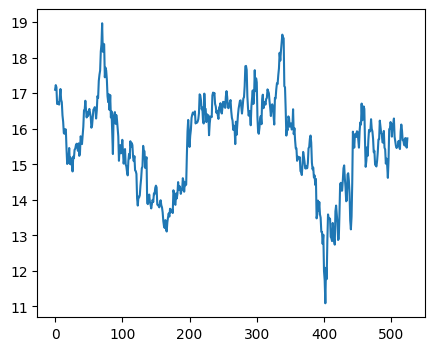

In [5]:
plt.figure(figsize=(5,4))
plt.plot(yahoo_stk_prices)
plt.show()

scaler = MinMaxScaler(feature_range=(0, 1))
yahoo_stk_prices = scaler.fit_transform(yahoo_stk_prices)

In [6]:
train_size = int(len(yahoo_stk_prices) * 0.80)
test_size = len(yahoo_stk_prices) - train_size
train, test = yahoo_stk_prices[0:train_size,:], yahoo_stk_prices[train_size:len(yahoo_stk_prices),:]
print(len(train), len(test))

420 105


In [7]:
train.shape

(420, 1)

In [8]:
test.shape

(105, 1)

In [9]:
#convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX,dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

In [10]:
#reshape into X=t and Y=t+1
look_back=1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [11]:
trainX[1]

array([0.7791877], dtype=float32)

In [12]:
trainY[0]

0.7791877

In [13]:
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [14]:
from tensorflow.keras.layers import Activation
import time

In [15]:
# Build a model
model= Sequential()
model.add(LSTM(100,
               input_shape=(1,look_back),
               return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(100,
               return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(100,
               input_dim=3,
               return_sequences=True))

model.add(Dense(1))
model.add(Activation('linear'))

start = time.time()
model.compile(loss='mse', optimizer='rmsprop')
print('compilation time : ', time.time() - start)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


compilation time :  0.007608175277709961


In [16]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 1, 100)              │          40,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1, 100)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 1, 100)              │          80,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 1, 100)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 1, 100)              │          80,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1, 1)                │             101 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 1, 1)                │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 201,701 (787.89 KB)

 Trainable params: 201,701 (787.89 KB)

 Non-trainable params: 0 (0.00 B)

In [17]:
model.fit(trainX,trainY,batch_size=128,epochs=20,validation_split=0.05)

Epoch 1/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 324ms/step - loss: 0.3717 - val_loss: 0.0390
Epoch 2/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.3191 - val_loss: 0.0271
Epoch 3/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.2712 - val_loss: 0.0169
Epoch 4/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.2369 - val_loss: 0.0102
Epoch 5/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.1804 - val_loss: 0.0083
Epoch 6/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.1290 - val_loss: 0.0147
Epoch 7/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0820 - val_loss: 0.0313
Epoch 8/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0505 - val_loss: 0.0539
Epoch 9/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0320 - val_loss: 0.0770
Epoch 10/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0258 - val_loss: 0.0940
Epoch 11/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0245 - val_loss: 0.0880
Epoch 12/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0256 - val_loss: 0.0922


In [18]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step
[[[0.5331998]]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step
[[[0.53319985]
  [1.2424968 ]]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
[[[0.53319985]
  [1.2424968 ]
  [2.0728724 ]]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
[[[0.53319985]
  [1.2424968 ]
  [2.0728724 ]
  [2.9136844 ]]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
[[[0.53319985]
  [1.2424968 ]
  [2.0728724 ]
  [2.9136844 ]
  [3.678581  ]]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
[[15.291615]
 [15.291615]
 [15.291615]
 [15.291615]
 [15.291615]]


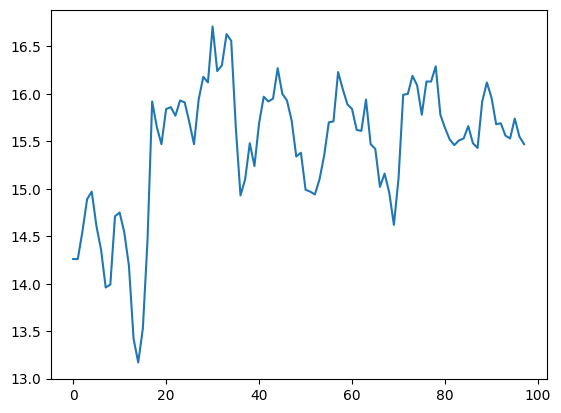

In [19]:
def plt_results_multiple(predicted_data, true_data,length):
    plt.plot(scaler.inverse_transform(true_data.reshape(-1,1))[length:])
    plt.plot(scaler.inverse_transform(np.array(predicted_data).reshape(-1,1))[length:])
    plt.show()

    # predict length consecutive values from real one
def predict_sequence_multiple(model, firstValue,length):
  prediction_seqs=[]
  curr_frame = firstValue

  for i in range(length):
    predicted = []
    print(model.predict(curr_frame[newaxis,:,:]))
    predicted.append(model.predict(curr_frame[newaxis,:,:])[0,0])

    curr_frame = curr_frame[0:]
    curr_frame = np.insert(curr_frame[0:],i+1,predicted[-1],axis=0)
    prediction_seqs.append(predicted[-1])
  return prediction_seqs

predict_length=5
predictions = predict_sequence_multiple(model,testX[0],predict_length)
print(scaler.inverse_transform(np.array(predictions).reshape(-1,1)))
plt_results_multiple(predictions,testY,predict_length)